In [ ]:
! pip install bigartm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd
import torch
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import spacy
import string
from sklearn.feature_extraction.text import CountVectorizer
from artm import BatchVectorizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import artm
import matplotlib.pyplot as plt

In [ ]:
! spacy download ru_core_news_lg -q

2023-12-24 05:19:24.034858: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-24 05:19:24.034927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-24 05:19:24.036309: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-24 05:19:25.350565: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.4/513.4 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 661.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 24.8 MB/s eta 0:00:0

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_parquet('/content/drive/My Drive/train.parquet')[:10000]
df_test = pd.read_parquet('/content/drive/My Drive/test.parquet')

In [ ]:
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
model = spacy.load('ru_core_news_lg')

In [ ]:
df_train.head()

,text,summary,topic,url,title,date
0,Сладострастник в течение трех лет преследовал ...,Старший преподаватель института коммунального ...,incident,https://www.mk.ru/incident/article/2010/01/05/...,Педофил преследовал подростка три года,06/01/2010
1,Буквально за час до боя курантов в подземном п...,Манежная площадь Москвы стала местом последнег...,incident,https://www.mk.ru/incident/article/2010/01/05/...,Таджики устроили резню на Манежной площади под...,06/01/2010
2,"Там они покатались на лыжах и снегоходах, пооб...",Президент РФ Дмитрий Медведев с семьей проводи...,politics,https://www.mk.ru/politics/article/2010/01/05/...,"""""""За все платит президент""""""",06/01/2010
3,Сосед расстрелял соседа из-за претензий по пов...,Первое убийство в 2010 году произошло в Москве...,incident,https://www.mk.ru/incident/article/2010/01/05/...,Первое убийство года спровоцировал потоп,06/01/2010
4,Причиной трагедии специалисты считают нарушени...,"Шесть человек, в том числе 9-летний ребенок, з...",incident,https://www.mk.ru/incident/article/2010/01/05/...,Целая семья не пережила газовой атаки,06/01/2010


In [ ]:
df_test.head()

,text,summary,topic,url,title,date
0,"Миллениалы, которые не знают, уходит электриче...",Кроме специальной антенны на окне и абонентско...,science,https://www.mk.ru/science/2019/05/31/sputniki-...,Спутники Илона Маска: будет ли «бесплатный инт...,01/06/2019
1,"Если верить южнокорейскому изданию, ссылающему...",Южнокорейские СМИ: наказание последовало за пр...,politics,https://www.mk.ru/politics/2019/05/31/eksperty...,Эксперты подвергли сомнению сообщения о казни ...,01/06/2019
2,ЦИТАТА ДНЯ Андрей ВОРОБЬЕВ: «Наша ключевая зад...,С 1 июня жители Московской области смогут полу...,mosobl,https://www.mk.ru/mosobl/2019/05/31/za-skoroy-...,За «скорой» установили всевидящее око,01/06/2019
3,В честь юбилея она выпустила клип на песню «Ка...,А слегка нетрезвая Алла Михеева прокатилась по...,culture,https://www.mk.ru/culture/2019/05/31/anzhelika...,Анжелика Варум рассказала историю одного одино...,01/06/2019
4,СПРАВКА «МК» 25 апреля 2019 года полковник бан...,Бывший владелец банка рассказал о печальных по...,social,https://www.mk.ru/social/2019/06/02/tayna-mill...,Тайна миллиардов сотрудника ФСБ Черкалина: кто...,03/06/2019


In [ ]:
def preprocess(text: str) -> str:
    text = re.sub('\d+', '', text)
    text = re.sub('[^\s^\w]+', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.lower()

    word_list = word_tokenize(text)
    stopwords_list = set(stopwords.words('russian'))

    word_list = [word for word in word_list if word not in stopwords_list]
    word_list = [word for word in word_list if len(word) > 2]
    word_list = [word for word in word_list if word not in string.punctuation]

    lemma = WordNetLemmatizer()
    word_list = [lemma.lemmatize(word) for word in word_list]
    text= ' '.join(word_list)

    return text

In [ ]:
df_train['text'] = df_train['text'].apply(lambda x: preprocess(x))
df_test['text'] = df_test['text'].apply(lambda x: preprocess(x))

In [ ]:
df_train = df_train.drop(columns=['summary', 'url', 'title', 'date'])
df_test = df_test.drop(columns=['summary', 'url', 'title', 'date'])

In [ ]:
mapper = {k: i for i, k in enumerate(df_train.topic.unique())}
df_train["topic"] = df_train["topic"].map(mapper)
df_test["topic"] = df_test["topic"].map(mapper)

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,3), max_features=20000)
m_tr = vectorizer.fit_transform(df_train['text'])
m_t = vectorizer.fit_transform(df_test['text'])

In [ ]:
n_wd_tr = m_tr.todense().T
n_wd_t = m_t.todense().T

In [ ]:
vocab = vectorizer.get_feature_names_out()

In [ ]:
vocab

array(['alekseev', 'big', 'bloomberg', ..., 'яшина', 'яшиным', 'ящик'],
      dtype=object)

In [ ]:
batch_vectorizer = BatchVectorizer(data_format='bow_n_wd', n_wd=n_wd_tr, vocabulary=vocab, target_folder='batches')

/usr/local/lib/python3.10/dist-packages/artm/batches_utils.py:227: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix


In [ ]:
dictionary = batch_vectorizer.dictionary

In [ ]:
lda = artm.LDA(num_topics=16, alpha=0.1, beta=0.1, num_document_passes=5, dictionary=dictionary)

In [ ]:
lda.fit_offline(batch_vectorizer, num_collection_passes=10)

In [ ]:
lda.phi_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, абу даби to традиции
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   topic_0   20000 non-null  float32
 1   topic_1   20000 non-null  float32
 2   topic_2   20000 non-null  float32
 3   topic_3   20000 non-null  float32
 4   topic_4   20000 non-null  float32
 5   topic_5   20000 non-null  float32
 6   topic_6   20000 non-null  float32
 7   topic_7   20000 non-null  float32
 8   topic_8   20000 non-null  float32
 9   topic_9   20000 non-null  float32
 10  topic_10  20000 non-null  float32
 11  topic_11  20000 non-null  float32
 12  topic_12  20000 non-null  float32
 13  topic_13  20000 non-null  float32
 14  topic_14  20000 non-null  float32
 15  topic_15  20000 non-null  float32
dtypes: float32(16)
memory usage: 1.4+ MB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
Phi = lda.phi_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
Phi

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15
абу даби,1.459401e-06,0.000605,2.206885e-04,2.898645e-04,3.495225e-04,1.721263e-04,1.493816e-04,1.233931e-06,1.437566e-04,4.182286e-05,5.771728e-06,3.482383e-04,1.943431e-04,8.018047e-04,8.622441e-06,5.301286e-05
абхазии,1.194961e-06,0.000064,2.506417e-05,4.647598e-05,4.607849e-05,5.844711e-06,5.736849e-06,8.912706e-07,2.343677e-05,1.942391e-06,5.742262e-06,1.336987e-04,1.204727e-05,2.118581e-04,2.516616e-06,7.267173e-06
аэропорту,1.507643e-05,0.000006,6.662445e-07,6.081512e-07,6.394101e-07,7.403020e-07,1.984222e-04,1.161284e-06,3.637882e-05,1.026911e-05,1.172393e-06,6.919088e-07,7.876931e-07,6.979437e-07,6.356087e-07,9.263778e-07
белым,1.794990e-04,0.000063,2.385146e-04,2.557394e-06,6.824889e-07,8.740133e-07,1.178983e-04,3.464182e-06,7.071991e-05,2.636668e-06,5.687723e-05,1.003823e-06,1.050044e-06,3.108142e-04,1.050190e-06,1.026002e-06
быстрый,2.480871e-05,0.000057,2.854691e-05,8.229289e-07,1.006429e-05,6.955604e-05,4.500212e-07,4.201129e-05,9.914070e-06,6.434818e-07,1.528144e-06,2.812140e-06,2.883994e-06,3.926674e-06,8.160017e-07,1.959128e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
полетом,3.571935e-07,0.000001,5.280238e-07,3.951893e-07,4.676616e-07,6.228204e-07,3.654193e-07,4.559763e-07,5.059234e-07,4.250855e-07,5.190570e-07,4.351202e-07,5.018965e-07,4.998656e-07,4.142124e-07,1.793801e-04
посетил,3.571935e-07,0.000001,5.281480e-07,3.951893e-07,4.676617e-07,6.228207e-07,3.654194e-07,4.559764e-07,5.059235e-07,4.250856e-07,5.190572e-07,4.351203e-07,5.018966e-07,4.998657e-07,4.142124e-07,2.837958e-04
посетили,3.571935e-07,0.000001,5.281026e-07,3.951893e-07,4.676616e-07,6.228206e-07,3.654194e-07,4.559763e-07,5.059234e-07,4.250855e-07,5.190571e-07,4.351202e-07,5.018965e-07,4.998657e-07,4.142124e-07,2.340740e-04
смирнова,3.571935e-07,0.000001,5.281026e-07,3.951893e-07,4.676616e-07,6.228206e-07,3.654194e-07,4.559763e-07,5.059234e-07,4.250855e-07,5.190571e-07,4.351202e-07,5.018965e-07,4.998657e-07,4.142124e-07,2.340740e-04


In [ ]:
lda.transform(batch_vectorizer)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,8000,8001,8002,8003,8004,8005,8006,8007,8008,8009,...,990,991,992,993,994,995,996,997,998,999
topic_0,0.000609,0.090090,0.513627,0.001700,0.002082,0.002351,0.476028,0.110037,0.003673,0.059196,...,0.002012,0.003352,0.003370,0.000941,0.002076,0.000776,0.005329,0.003912,0.003246,0.006888
topic_1,0.000641,0.012363,0.001929,0.011271,0.001507,0.002213,0.001679,0.001408,0.001369,0.001402,...,0.006805,0.003089,0.004401,0.021320,0.001325,0.376856,0.005402,0.002061,0.004449,0.004911
topic_2,0.027168,0.021059,0.000797,0.018829,0.000910,0.051955,0.007981,0.006929,0.000888,0.346669,...,0.286700,0.023383,0.381577,0.135623,0.004247,0.000695,0.007632,0.106111,0.003332,0.004886
topic_3,0.522001,0.000739,0.003111,0.001632,0.001210,0.001186,0.001376,0.000915,0.001218,0.000603,...,0.002647,0.004256,0.002802,0.000660,0.016178,0.003035,0.004257,0.004155,0.005711,0.220879
topic_4,0.331541,0.001184,0.000848,0.002063,0.294275,0.735035,0.172883,0.001444,0.000816,0.357361,...,0.002435,0.029411,0.005188,0.310499,0.050625,0.058617,0.003923,0.004569,0.004819,0.005751
topic_5,0.000613,0.038753,0.000913,0.083290,0.000980,0.002828,0.000690,0.064135,0.000901,0.000984,...,0.002869,0.006682,0.572370,0.499300,0.001755,0.000786,0.004591,0.003081,0.008632,0.004492
topic_6,0.000444,0.011856,0.027899,0.001311,0.049277,0.001471,0.131637,0.197605,0.242834,0.000335,...,0.012637,0.005282,0.002775,0.001208,0.002396,0.000645,0.010688,0.002864,0.004449,0.518059
topic_7,0.062013,0.020931,0.000915,0.094700,0.002181,0.003712,0.183802,0.006636,0.001126,0.004708,...,0.002266,0.011532,0.003667,0.002405,0.002280,0.030495,0.571252,0.002543,0.020633,0.016915
topic_8,0.000278,0.436132,0.006182,0.272751,0.002619,0.001338,0.000929,0.255824,0.155244,0.000297,...,0.570981,0.269947,0.002327,0.000951,0.006057,0.001189,0.049427,0.192605,0.005450,0.042593
topic_9,0.000808,0.039098,0.006790,0.020406,0.005011,0.003274,0.004057,0.054294,0.426068,0.023140,...,0.001953,0.003646,0.002531,0.000814,0.005615,0.046100,0.116323,0.002858,0.019954,0.019323


In [ ]:
lda.phi_['topic_0'].nlargest(n=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


этим согласны    0.027386
очень сильно     0.010896
проходила        0.006829
магазины         0.005213
воспитанию       0.004511
детских садов    0.003827
жээнбеков        0.003726
нападающего      0.003702
челноков         0.003618
лечиться         0.003349
Name: topic_0, dtype: float32

In [ ]:
lda.phi_['topic_1'].nlargest(n=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


этим согласны     0.006947
львов             0.005072
продал            0.004882
распределения     0.004190
лечиться          0.003885
феврале года      0.003677
станиславского    0.003431
сашка             0.003424
русского          0.003355
гора              0.003192
Name: topic_1, dtype: float32

In [ ]:
lda.phi_['topic_2'].nlargest(n=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


обладать           0.007604
мотивах            0.007075
государственной    0.006142
этим согласны      0.005921
городам            0.005903
будущее            0.005092
гора               0.004650
мошенничество      0.004532
тихого             0.004373
судебный           0.004152
Name: topic_2, dtype: float32

In [ ]:
lda.perplexity_last_value

5451.5634765625

In [ ]:
lda.perplexity_value

[19867.708984375,
 8456.21484375,
 8359.9541015625,
 8139.80908203125,
 7701.64111328125,
 7130.82568359375,
 6661.07958984375,
 6344.2490234375,
 6122.9638671875,
 5959.13623046875,
 5835.158203125,
 5741.09521484375,
 5669.541015625,
 5614.54248046875,
 5571.48291015625,
 5537.171875,
 5509.44140625,
 5486.56396484375,
 5467.517578125,
 5451.5634765625]

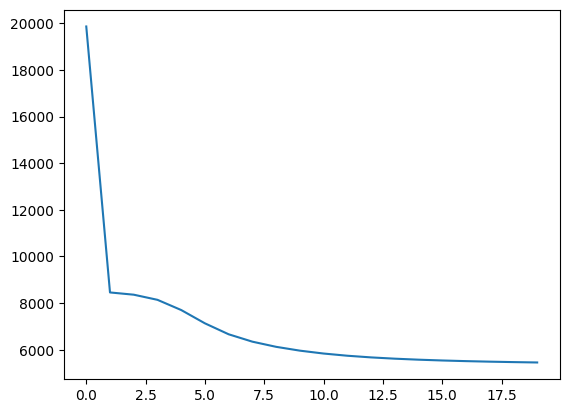

In [ ]:
plt.plot(lda.perplexity_value)

In [ ]:
batch_vectorizer_test = BatchVectorizer(data_format='bow_n_wd', n_wd=n_wd_t, vocabulary=vocab, target_folder='batches_test')

In [ ]:
lda.transform(batch_vectorizer_test)

,0,1,2,3,4,5,6,7,8,9,...,747,748,749,750,751,752,753,754,755,756
topic_0,0.080355,0.080468,0.049040,0.084992,0.092862,0.082207,0.048078,0.093114,0.051861,0.064863,...,0.095074,0.066104,0.058660,0.056004,0.056886,0.080056,0.050763,0.068938,0.049867,0.155284
topic_1,0.064964,0.040012,0.027821,0.101815,0.059284,0.036793,0.052330,0.027252,0.127979,0.065641,...,0.081311,0.020288,0.049113,0.012171,0.037386,0.042664,0.041789,0.031643,0.072566,0.017334
topic_2,0.032578,0.106876,0.131251,0.037938,0.047354,0.074617,0.084565,0.088280,0.030827,0.048365,...,0.056201,0.059367,0.056996,0.080567,0.081291,0.046130,0.071026,0.055786,0.095045,0.035459
topic_3,0.067557,0.080758,0.080348,0.095662,0.138209,0.033965,0.118185,0.123040,0.155805,0.092616,...,0.053296,0.079901,0.050121,0.043254,0.071863,0.096233,0.090304,0.067514,0.035665,0.031410
topic_4,0.073598,0.038846,0.066542,0.050429,0.042299,0.046371,0.075931,0.046075,0.034437,0.069041,...,0.075468,0.078853,0.031798,0.010883,0.053571,0.108993,0.061069,0.052858,0.081219,0.048850
topic_5,0.046509,0.063389,0.060944,0.042959,0.036807,0.034114,0.058053,0.034555,0.054731,0.070843,...,0.040740,0.030690,0.046041,0.014929,0.061892,0.100821,0.045716,0.077973,0.039798,0.054279
topic_6,0.040232,0.080117,0.082584,0.098109,0.035840,0.089635,0.053997,0.055713,0.041998,0.053572,...,0.089070,0.056311,0.104490,0.096482,0.047825,0.040901,0.078034,0.079834,0.082720,0.082460
topic_7,0.029586,0.024555,0.069370,0.020496,0.039723,0.017237,0.023569,0.026518,0.027852,0.030267,...,0.046911,0.082861,0.037801,0.117573,0.044846,0.029093,0.039155,0.052890,0.043690,0.029464
topic_8,0.059855,0.034703,0.015044,0.068868,0.058018,0.050349,0.065123,0.038494,0.058406,0.031240,...,0.035125,0.069145,0.023142,0.015501,0.052972,0.046473,0.080083,0.039883,0.042130,0.040141
topic_9,0.065236,0.103007,0.048527,0.032150,0.081534,0.051958,0.062306,0.072378,0.066497,0.045338,...,0.086734,0.056470,0.099037,0.084590,0.143995,0.047429,0.018998,0.046634,0.094503,0.072629


In [ ]:
model = artm.ARTM(num_topics=15)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model.scores.add(artm.PerplexityScore(name='perplexity_score'))
model.scores.add(artm.TopTokensScore(name='top_tokens_score'))

In [ ]:
model.num_document_passes = 3

In [ ]:
model.initialize(dictionary=dictionary)

In [ ]:
model.fit_offline(batch_vectorizer, num_collection_passes=5)

In [ ]:
model.score_tracker['perplexity_score'].last_value

8446.091796875

In [ ]:
model.score_tracker['perplexity_score'].value

[19914.6171875,
 8523.1552734375,
 8512.505859375,
 8490.103515625,
 8446.091796875]

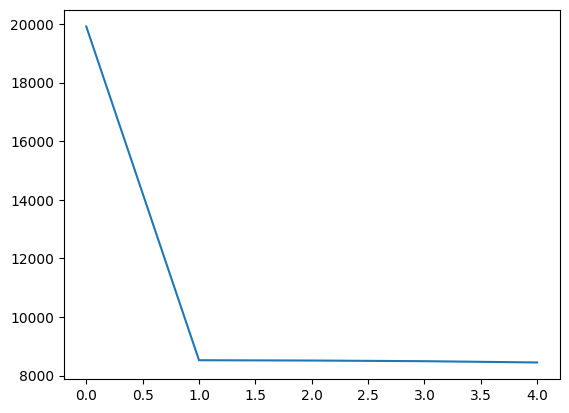

In [ ]:
plt.plot(model.score_tracker['perplexity_score'].value)

In [ ]:
model.score_tracker['top_tokens_score'].last_tokens

{'topic_0': ['этим согласны',
  'очень сильно',
  'проходила',
  'кремер',
  'городам',
  'нападающего',
  'будущее',
  'почва',
  'магазины',
  'мотивах'],
 'topic_1': ['этим согласны',
  'рубеж',
  'красным',
  'очень сильно',
  'десять минут',
  'русского',
  'жээнбеков',
  'лечиться',
  'гонорар',
  'воспользоваться'],
 'topic_2': ['этим согласны',
  'гора',
  'проходила',
  'кремер',
  'челноков',
  'лечиться',
  'городам',
  'очень сильно',
  'убежище',
  'вспоминает'],
 'topic_3': ['этим согласны',
  'челноков',
  'кремер',
  'гора',
  'вспоминает',
  'красным',
  'поймет',
  'детских садов',
  'потребовала',
  'очень сильно'],
 'topic_4': ['этим согласны',
  'гора',
  'красным',
  'очень сильно',
  'проходила',
  'кремер',
  'лечиться',
  'русского',
  'рубеж',
  'мотивах'],
 'topic_5': ['этим согласны',
  'гора',
  'вспоминает',
  'поймет',
  'очень сильно',
  'будущее',
  'хочу сказать',
  'русского',
  'мотивах',
  'магазины'],
 'topic_6': ['этим согласны',
  'рубеж',
  'леч

In [ ]:
model.transform(batch_vectorizer)

,8000,8001,8002,8003,8004,8005,8006,8007,8008,8009,...,990,991,992,993,994,995,996,997,998,999
topic_0,0.057139,0.063524,0.059868,0.053812,0.062314,0.047515,0.080166,0.062734,0.055698,0.071473,...,0.040504,0.043656,0.089911,0.070003,0.063381,0.055841,0.063373,0.065406,0.109118,0.055617
topic_1,0.085987,0.066232,0.058071,0.059519,0.080923,0.062439,0.073067,0.064284,0.062237,0.071079,...,0.059412,0.047456,0.038803,0.086757,0.059813,0.097555,0.077936,0.062166,0.055508,0.030037
topic_2,0.067273,0.064171,0.064528,0.070077,0.058645,0.090165,0.065151,0.057033,0.088105,0.066300,...,0.095338,0.078072,0.127475,0.088812,0.043574,0.069442,0.053731,0.083753,0.067363,0.063406
topic_3,0.092579,0.076626,0.056272,0.053128,0.050099,0.044436,0.070152,0.093406,0.067797,0.053278,...,0.076000,0.080961,0.022373,0.033453,0.070523,0.055375,0.073892,0.096126,0.046303,0.111477
topic_4,0.044589,0.077754,0.063280,0.049979,0.070993,0.069650,0.083063,0.049981,0.051860,0.091047,...,0.052558,0.061882,0.111874,0.074776,0.070889,0.072799,0.041288,0.080209,0.044722,0.020877
topic_5,0.049275,0.076829,0.054416,0.100933,0.087715,0.078913,0.061637,0.055740,0.062185,0.086497,...,0.068747,0.057822,0.085774,0.108761,0.066587,0.076599,0.048587,0.043626,0.051628,0.041239
topic_6,0.033816,0.068051,0.072704,0.083990,0.057633,0.028316,0.068606,0.086894,0.079142,0.066343,...,0.103688,0.080538,0.059565,0.052387,0.044309,0.071233,0.089944,0.066618,0.095400,0.085353
topic_7,0.069271,0.068559,0.070499,0.064622,0.073656,0.072647,0.074872,0.066348,0.038802,0.069162,...,0.074044,0.080344,0.101441,0.072032,0.066735,0.069436,0.092738,0.046878,0.079262,0.065426
topic_8,0.048253,0.061423,0.081372,0.085992,0.046200,0.063335,0.056848,0.082812,0.064348,0.074723,...,0.061568,0.069082,0.043998,0.052568,0.046083,0.067404,0.077981,0.081394,0.045129,0.091658
topic_9,0.044179,0.051579,0.077406,0.075707,0.075024,0.067713,0.056237,0.061236,0.083038,0.059051,...,0.064778,0.059524,0.057539,0.041959,0.081102,0.066180,0.071029,0.065885,0.057642,0.080608


In [ ]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=-4))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model.initialize(dictionary)

In [ ]:
model.master.clear_score_array_cache()

In [ ]:
model.fit_offline(batch_vectorizer, num_collection_passes=5)

In [ ]:
model.score_tracker['perplexity_score'].value

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[19914.6171875, 9888.732421875, 8445.5693359375, 8308.1552734375, 8184.59375]

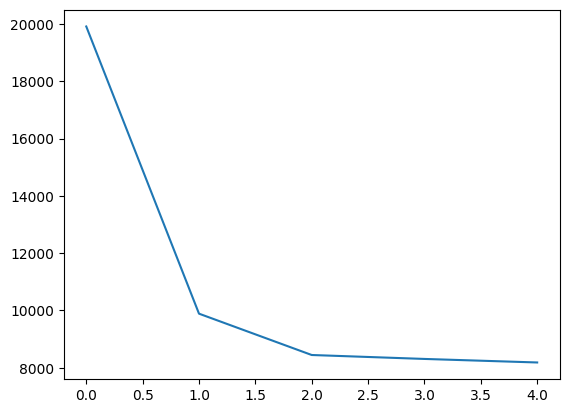

In [ ]:
plt.plot(model.score_tracker['perplexity_score'].value)

In [ ]:
model.phi_['topic_0'].nlargest(n=10)

этим согласны    0.015130
очень сильно     0.005921
проходила        0.004911
кремер           0.004634
городам          0.003630
нападающего      0.003601
почва            0.003342
будущее          0.003289
магазины         0.003183
институт         0.003096
Name: topic_0, dtype: float32

In [ ]:
model.transform(batch_vectorizer_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9,...,747,748,749,750,751,752,753,754,755,756
topic_0,0.091691,0.053606,0.057578,0.059022,0.057220,0.043233,0.076784,0.095881,0.096561,0.086035,...,0.060505,0.039061,0.035150,0.133275,0.059365,0.060758,0.062638,0.084502,0.027581,0.076170
topic_1,0.046895,0.061980,0.048583,0.047797,0.050142,0.084104,0.041961,0.027569,0.054287,0.029936,...,0.052273,0.044633,0.064130,0.032683,0.055819,0.110657,0.058292,0.043694,0.034472,0.059621
topic_2,0.056392,0.040054,0.080393,0.074432,0.119117,0.078187,0.065224,0.070711,0.054146,0.061879,...,0.066997,0.080034,0.062417,0.063396,0.068947,0.043189,0.051075,0.077601,0.086695,0.019407
topic_3,0.027455,0.067526,0.044803,0.038275,0.067133,0.029835,0.067969,0.073269,0.081486,0.047137,...,0.057595,0.053549,0.064348,0.069781,0.075292,0.138557,0.036689,0.062167,0.067652,0.069389
topic_4,0.068998,0.058499,0.083572,0.051754,0.049859,0.056635,0.089335,0.047122,0.086523,0.078132,...,0.057245,0.064525,0.030355,0.027208,0.077473,0.049565,0.092887,0.054430,0.059044,0.050440
topic_5,0.072399,0.133428,0.092888,0.046156,0.046993,0.075496,0.058295,0.060539,0.053747,0.059487,...,0.078795,0.090057,0.025178,0.033249,0.089639,0.034505,0.054906,0.068829,0.058287,0.063193
topic_6,0.055200,0.036687,0.030405,0.069228,0.048845,0.097442,0.062474,0.071349,0.057700,0.033707,...,0.047963,0.051852,0.116252,0.055079,0.065847,0.036180,0.063076,0.054738,0.062953,0.055388
topic_7,0.082089,0.089366,0.061922,0.102505,0.059502,0.089738,0.043611,0.049368,0.103618,0.069603,...,0.083017,0.082369,0.055434,0.060647,0.061613,0.052937,0.069151,0.079506,0.077224,0.077312
topic_8,0.069963,0.062869,0.062169,0.061284,0.051837,0.063253,0.114002,0.091849,0.057605,0.098946,...,0.080485,0.066427,0.071231,0.079294,0.056981,0.094969,0.069841,0.069468,0.065594,0.070004
topic_9,0.065180,0.046922,0.087063,0.043670,0.076267,0.073326,0.045342,0.058441,0.072028,0.098803,...,0.052721,0.082961,0.080694,0.130680,0.074755,0.069495,0.041435,0.049152,0.104719,0.126084


In [ ]:
Doc_topic = model.transform(batch_vectorizer_test).idxmax()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
Doc_topic

0      topic_14
1       topic_5
2      topic_14
3      topic_14
4      topic_14
         ...   
752     topic_3
753    topic_14
754    topic_14
755    topic_10
756     topic_9
Length: 757, dtype: object

In [ ]:
model.phi_['topic_14'].nlargest(n=10)

этим согласны    0.022026
вспоминает       0.006150
рубеж            0.005662
хочу сказать     0.003684
гора             0.003313
проходила        0.003110
очень сильно     0.003109
жээнбеков        0.002928
магазины         0.002768
потребовала      0.002698
Name: topic_14, dtype: float32